In [1]:
import pandas as pd
import os

import scipy.stats
from scipy.stats import hypergeom
import statsmodels.stats.multitest as smm
import matplotlib.pyplot as plt
from itertools import combinations
%pylab inline
import collections
import numpy

Populating the interactive namespace from numpy and matplotlib


In [2]:
import statistics 

In [3]:

#single cell DE data as binary matrix 
sc=pd.read_csv("../../data/scRNAseq_Cengen2020/071020_sc_neuron_class_vs_all_DE_WX_binary.csv",sep=',')

#import brain atlas data
ba=pd.read_csv("../../data/BrainAtlas/Binary Brain atlas V17_w_120619_HB_data_Jan_10_2020.csv",sep=",")

#all C. elegans TFs
All_eleg_TFs=pd.read_csv("../../data/motif_information/Table_1_Ce_TF_list_Wormbook_2013 Reinke et al.csv",sep=',')

#motif data
cdat=pd.read_csv("../../data/motif_information/curated_motifs_071320b_with_neuron_class_expression_per_dataset.csv",sep=',')


In [6]:
cdat["exclusion_rule"].drop_duplicates()

0      None
132       7
139       0
151       2
158       4
160       5
161       6
207       3
Name: exclusion_rule, dtype: object

In [7]:
#how many motifs were exlues due to ambiguity
print("unique motifs")
#(subtract 1 since ttx-3--ceh-10 is listed as TF (both are indiviudally present as well))
print(len(cdat.loc[cdat['exclusion_rule'].isin(["None"])]["TF_Name"].drop_duplicates())-1)

print("\n neuronal TF with no motif:", len(cdat.loc[cdat['exclusion_rule'].isin(["0"])]))

unique motifs
136

 neuronal TF with no motif: 188


In [8]:
#all neuronal TFs:
print(len(cdat["TF_Name"].drop_duplicates())-1)

418


In [11]:
def get_sc_genes(neuron_class):
    r=sorted(list(sc.loc[sc[neuron_class]==1]["gene_name"].values))
    return r
        
   
def get_ba_genes(neuron_class):
    df=ba.loc[ba["class"]==neuron_class]
    
    df=df.transpose()[4:]
    df.columns=list(range(len(df.columns)))
    genes=[]
    for i in range(len(df.columns)):
        g=list(df.index[df[i]==1])
        genes=genes+g
    #if gene is in isoform notation, reduce to main gene name (targetortho doesn't distinguish isoforms)
    correct_these={'inx-1a':'inx-1','inx-1b':'inx-1','inx-18a':'inx-18','inx-18b':'inx-18','inx-10a':'inx-10','inx-10b':'inx-10'}
    genes_corrected=[]
    for gene in genes:
        if gene not in correct_these.keys():
            genes_corrected.append(gene)
        else:
            genes_corrected.append(correct_these[gene])
    genes=list(set(genes_corrected))
    return sorted(list(set(genes)))

In [13]:
# for each neuron class in sc data, get common markers with ba
plist=[]
for nc in sc.columns.values:
    try:
        sc_genes=set(get_sc_genes(nc))
        ba_genes=set(get_ba_genes(nc))
        all_genes=set(list(sc_genes)+list(ba_genes))
        common=sc_genes&ba_genes
        p=len(common)/len(all_genes)
        #print(nc,p)
        plist.append(p)
    except:
        None
    
print(min(plist),max(plist),sum(plist)/float(len(plist)))

0.0 0.1111111111111111 0.044613101707869515


(array([ 3., 18., 30., 17., 14., 15.,  6.,  6.,  6.,  3.]),
 array([0.        , 0.01111111, 0.02222222, 0.03333333, 0.04444444,
        0.05555556, 0.06666667, 0.07777778, 0.08888889, 0.1       ,
        0.11111111]),
 <a list of 10 Patch objects>)

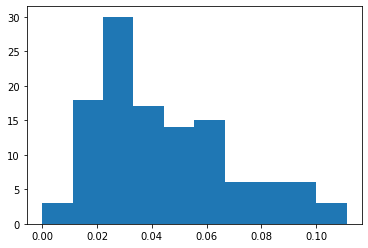

In [84]:
plt.hist(plist)


In [85]:
th_data=pd.read_csv("../../data/scRNAseq_Cengen2020/040820_Neuron_type_expression_medium_2.csv",sep=',')
#th_data=pd.read_csv("../data/scRNAseq_Cengen2020/040820_Neuron_type_expression_liberal_1.csv",sep=',')

col_names=th_data["gene_name"].values
print(len(col_names))

#transpose threshold data then change neuron names to class names (use same map as R script)
#set index to gene names
d=th_data.T
d.columns=col_names
d.index.name='neuron_class'
d=d[2:]
d=d.reset_index()
d.head(2)

13669


neuron_class   nduo-6    ndfl-4    MTCE.7    nduo-1    atp-6    nduo-2  \
0          ADA  6.57261  0.844884  0.879538   1.33993  3.77558  0.234323   
1          ADE  11.1291   1.13786   1.31947  0.503282  4.52954  0.207877   

      ctb-1    ctc-3    nduo-4  ... srd-17 F09C12.2 F35F11.3 K01A6.18 F56D6.8  \
0  0.775578  4.13531  0.556106  ...      0        0        0        0       0   
1  0.781182  1.98031  0.671772  ...      0        0        0        0       0   

  C50D2.3 gst-35 C28C12.11 T12F5.2 ref-1  
0       0      0         0       0     0  
1       0      0         0       0     0  

[2 rows x 13670 columns]

In [86]:
#get a list of TFs in sc and ba data.
sc_genes=set(list(sc["gene_name"].values)[2:])

ba_genes=set(list(ba.columns.values)[4:])
all_genes=sc_genes | ba_genes
all_TFs=set(list(All_eleg_TFs["Gene Public Name"].values)+list(All_eleg_TFs["Sequence Name (Gene)"].values))
ba_TFs=set(all_TFs & ba_genes)
sc_TFs=set(all_TFs & sc_genes)



#get list of sc_TFs that are expressed in threshold 2 data
Th2_genes=set(list(d.columns.values[1:]))
print('len Th2 genes: ', len(Th2_genes),'len Th2 genes in scTFs: ', len(Th2_genes&sc_TFs))
print('len ba genes', len(ba_genes))
print('len sc genes', len(sc_genes))

sc_TFs_in_th2=Th2_genes&sc_TFs
print('scTFs, scTFs in th2 data',len(sc_TFs),len(sc_TFs_in_th2))

n_TFs=set(all_TFs & all_genes)
all_TF_len=len(list(All_eleg_TFs["Gene Public Name"].values))
TF_w_motif=set(list(cdat.loc[cdat['exclusion_rule']=='None']["TF_Name"].drop_duplicates().values))

#print TF stats (regardless of motif status)
print('total TFs c. elegans:', all_TF_len)
print('brain atlas TFs:',len(ba_TFs))
print('sc neuronal TFs:', len(sc_TFs))
print('common neuronal TFs (BA and sc data):', len(set(ba_TFs & sc_TFs)))
print('total neuronal TFs in BA + sc data:',  len(n_TFs))

#stats for TFs with motifs (subtract 1 since ttx-3--ceh-10 is listed as TF (both are indiviudally present as well))
print('all TFs with motif:', len(TF_w_motif)-1)
print('brain atlas TF with motif:', len(TF_w_motif&ba_TFs)-1)
print('sc TF with motif:', len(TF_w_motif&sc_TFs)-1)

print('common neuronal TFs with motif:', len(set(ba_TFs & sc_TFs)& TF_w_motif)-1)


#single neuron clusters:  82

len Th2 genes:  13669 len Th2 genes in scTFs:  372
len ba genes 1217
len sc genes 6766
scTFs, scTFs in th2 data 372 372
total TFs c. elegans: 924
brain atlas TFs: 164
sc neuronal TFs: 372
common neuronal TFs (BA and sc data): 121
total neuronal TFs in BA + sc data: 415
all TFs with motif: 137
brain atlas TF with motif: 89
sc TF with motif: 122
common neuronal TFs with motif: 76


In [87]:
import matplotlib_venn as venn

In [88]:

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
 


all TFs with motif: 137
brain atlas TF with motif: 89
sc TF with motif: 122
common neuronal TFs with motif: 76


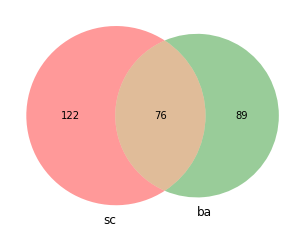

In [89]:
#stats for TFs with motifs (subtract 1 since ttx-3--ceh-10 is listed as TF (both are indiviudally present as well))
print('all TFs with motif:', len(TF_w_motif)-1)
print('brain atlas TF with motif:', len(TF_w_motif&ba_TFs)-1)
print('sc TF with motif:', len(TF_w_motif&sc_TFs)-1)

print('common neuronal TFs with motif:', len(set(ba_TFs & sc_TFs)& TF_w_motif)-1)

venn2(subsets = (122, 89, 76), set_labels = ('sc', 'ba'))
plt.show()

total TFs c. elegans: 924
brain atlas TFs: 164
sc neuronal TFs: 372
common neuronal TFs (BA and sc data): 121
total neuronal TFs in BA + sc data: 415


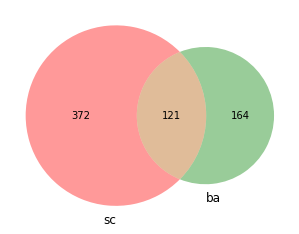

In [90]:
#print TF stats (regardless of motif status)
print('total TFs c. elegans:', all_TF_len)
print('brain atlas TFs:',len(ba_TFs))
print('sc neuronal TFs:', len(sc_TFs))
print('common neuronal TFs (BA and sc data):', len(set(ba_TFs & sc_TFs)))
print('total neuronal TFs in BA + sc data:',  len(n_TFs))
venn2(subsets = (372, 164, 121), set_labels = ('sc', 'ba'))
plt.show()
 


In [112]:
#motif overview:
#direct vs inferred
cdat_N=cdat.loc[cdat['exclusion_rule']=="None"]
#experimental source
i=0
l=list(cdat_N["TF_Status"].values)
print(l)
print(l.count('D'))
print(l.count('I'))

['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'I', 'D', 'D', 'I', 'D', 'D', 'D', 'D', 'I', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'I', 'D', 'I', 'I', 'I', 'I', 'D', 'I', 'D', 'D', 'D', 'I', 'D', 'I', 'D', 'I', 'D', 'D', 'I', 'I', 'I', 'I', 'D', 'I', 'D', 'D', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'D', 'D', 'D', 'D', 'D', 'I', 'I', 'D', 'D', 'D', 'D', 'D', 'I', 'D', 'I', 'I', 'D', 'I', 'D', 'I', 'D', 'I', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'I', 'D', 'I', 'I', 'D', 'I', 'D', 'D', 'D', 'D', 'I', 'I', 'D', 'D', 'D']
95
44


In [27]:
cdat.columns.values

array(['Unnamed: 0', 'DNA domain', 'TF_Name', 'TF_Status', 'TF_ID',
       'motif_ID', 'protein', 'species', 'SR', 'similar', 'MSource_type',
       'MSource_Author_Year', 'exclusion_rule',
       'proportion of neuron classes expressed in both data sets',
       'len_t2', 'len_ba', 'sc-ba',
       'single cell DE data: neuron classes that express (threshold 2)',
       'brain atlas data: neuron classes that express', 'common',
       'different'], dtype=object)

In [108]:
TF_Status=list(cdat['TF_Status'].values)
cdat_x=cdat.loc[cdat['exclusion_rule']=='None']
MSource_type=list(cdat_x['MSource_type'].values)
d=pd.DataFrame()
headers=['Experimental Source','Motif Count','References']
for m in set(MSource_type):
    
    #c=MSource_type.count(m)
    
    c=len(cdat_x.loc[cdat_x['MSource_type']==m]["TF_Name"].drop_duplicates().values)
    
    s=sorted(list(cdat_x.loc[cdat_x['MSource_type']==m]['MSource_Author_Year'].drop_duplicates().values))
    s_string=''
    for i in s:
        s_string=s_string+'%s, ' %i
    results=[m,c,s_string]
    
    dictionary = dict(zip(headers, results))
    d=d.append(dictionary,ignore_index=True)
d=d[headers]
d=d.sort_values(ascending=False,by=['Motif Count'])
d.to_csv('../../output/figure_parts/exmperimental_source_motif_count.csv',sep=',')

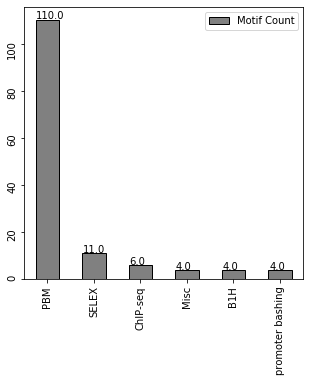

In [92]:


ax=d.plot.bar(legend=True,stacked=False,figsize=(5,5),color=['grey'],edgecolor='black',rot=90)
xlabels=d["Experimental Source"].values
ax.set_xticklabels(xlabels, rotation=90)
plt.yticks(rotation=90)
ax.grid(False)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))



In [93]:
sum(d["Motif Count"]) #2 unc-86 motifs and AIY motif mean there should be 2 more motifs than TFs. 

139.0

In [31]:
sc.head(2)

Unnamed: 0  gene_name  PVP  RMH  RIP  PVT  AVH  M2  PVN  HSN  ...  PVC  \
0           1  21ur-7131    0    0    0    0    0   0    0    0  ...    1   
1           2  21ur-8256    0    0    0    0    0   0    0    0  ...    1   

   PVQ  ADF  RIS  ASJ  ASG  RIM  AIB  RIV  IL1  
0    0    0    0    0    0    1    0    0    0  
1    0    0    0    0    0    1    0    0    0  

[2 rows x 119 columns]

In [94]:
#make bar chart of neuron classes x markers for each data source
sc_nclasses=sorted(list(sc.columns.values)[1:])
ba_nclasses=sorted(list(ba["class"].drop_duplicates().values))
d=pd.DataFrame()
headers=['ba','sc','ba_c','sc_c']
#get gene count for each neuron class (use ba as ref since all classes are there. If missing from sc data, fill with 0)

ba_nclasses=[i for i in ba_nclasses if i not in ['DD','VD']]
ba_nclasses=ba_nclasses+['DD','VD']
for n in ba_nclasses:
    print(n)
    
    ba_c=get_ba_genes(n)
    sc_n=n
    if n in sc_nclasses:
        sc_c=get_sc_genes(n)
    elif n in ['DD']:
        sc_c=get_sc_genes('VD_DD')
    else:
        sc_c=[]
    result=[n,sc_n, len(ba_c),len(sc_c)]
    dictionary = dict(zip(headers, result))
    d=d.append(dictionary,ignore_index=True)

ADA
ADE
ADF
ADL
AFD
AIA
AIB
AIM
AIN
AIY
AIZ
ALA
ALM
ALN
AQR
AS
ASE
ASG
ASH
ASI
ASJ
ASK
AUA
AVA
AVB
AVD
AVE
AVF
AVG
AVH
AVJ
AVK
AVL
AVM
AWA
AWB
AWC
BAG
BDU
CAN
CEP
DA
DB
DVA
DVB
DVC
FLP
HSN
I1
I2
I3
I4
I5
I6
IL1
IL2
LUA
M1
M2
M3
M4
M5
MC
MI
NSM
OLL
OLQ
PDA
PDB
PDE
PHA
PHB
PHC
PLM
PLN
PQR
PVC
PVD
PVM
PVN
PVP
PVQ
PVR
PVT
PVW
RIA
RIB
RIC
RID
RIF
RIG
RIH
RIM
RIP
RIR
RIS
RIV
RMD
RME
RMF
RMG
RMH
SAA
SAB
SDQ
SIA
SIB
SMB
SMD
URA
URB
URX
URY
VA
VB
VC
DD
VD


In [95]:
d.loc[d['sc']=='BDU']

ba  ba_c   sc   sc_c
38  BDU  68.0  BDU  259.0

259.0
40.0 1280.0


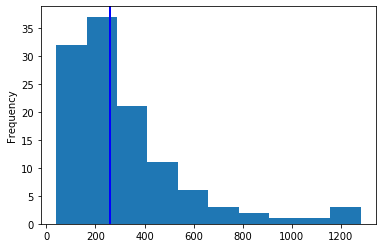

In [96]:
x=d[['sc','sc_c']].loc[d[['sc','sc_c']]['sc_c']!=0]["sc_c"]
print(x.median())
print(min(x),max(x))
ax=x.plot.hist()
ax.axvline(x.median(), color='blue', linewidth=2)

57.5
34.0 254.0


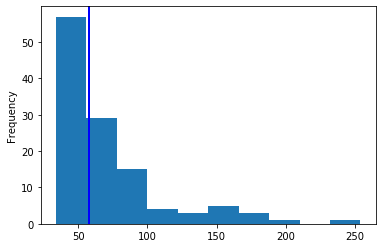

In [97]:
x=d[['ba','ba_c']].loc[d[['ba','ba_c']]['ba_c']!=0]["ba_c"]
print(x.median())
print(min(x),max(x))
ax=x.plot.hist()
ax.axvline(x.median(), color='blue', linewidth=2)

['ADA', 'ADE', 'ADF', 'ADL', 'AFD', 'AIA', 'AIB', 'AIM', 'AIN', 'AIY', 'AIZ', 'ALA', 'ALM', 'ALN', 'AQR', 'AS', 'ASE', 'ASG', 'ASH', 'ASI', 'ASJ', 'ASK', 'AUA', 'AVA', 'AVB', 'AVD', 'AVE', 'AVF', 'AVG', 'AVH', 'AVJ', 'AVK', 'AVL', 'AVM', 'AWA', 'AWB', 'AWC', 'BAG', 'BDU', 'CAN', 'CEP', 'DA', 'DB', 'DVA', 'DVB', 'DVC', 'FLP', 'HSN', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'IL1', 'IL2', 'LUA', 'M1', 'M2', 'M3', 'M4', 'M5', 'MC', 'MI', 'NSM', 'OLL', 'OLQ', 'PDA', 'PDB', 'PDE', 'PHA', 'PHB', 'PHC', 'PLM', 'PLN', 'PQR', 'PVC', 'PVD', 'PVM', 'PVN', 'PVP', 'PVQ', 'PVR', 'PVT', 'PVW', 'RIA', 'RIB', 'RIC', 'RID', 'RIF', 'RIG', 'RIH', 'RIM', 'RIP', 'RIR', 'RIS', 'RIV', 'RMD', 'RME', 'RMF', 'RMG', 'RMH', 'SAA', 'SAB', 'SDQ', 'SIA', 'SIB', 'SMB', 'SMD', 'URA', 'URB', 'URX', 'URY', 'VA', 'VB', 'VC', 'VD & DD']


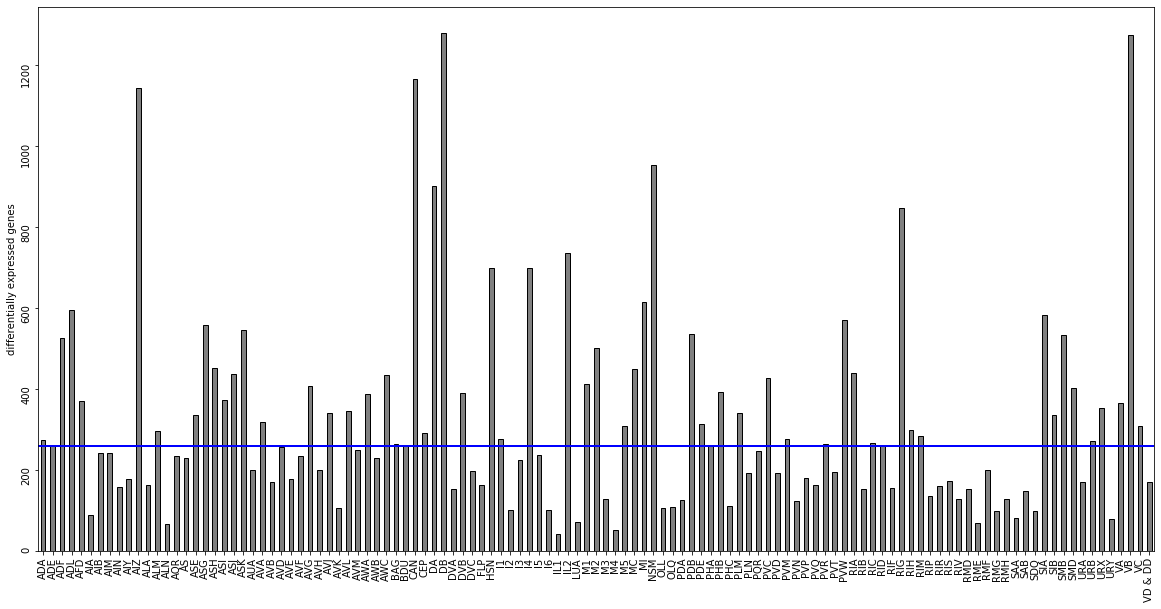

In [98]:
ax=d[['sc','sc_c']].loc[(d[['sc','sc_c']]['sc_c']!=0) & (d[['sc','sc_c']]['sc']!='VD')].plot.bar(legend=False,stacked=False,figsize=(20,10),color=['grey'],edgecolor='black',rot=90)
#plt.ylim(0,250)
x=d[['sc','sc_c']].loc[(d[['sc','sc_c']]['sc_c']!=0) & (d[['sc','sc_c']]['sc']!='VD')]["sc_c"]
ax.axhline(x.median(), color='blue', linewidth=2)

xlabels=list(d["sc"].drop_duplicates().values[:-2])
xlabels.append('VD & DD')
print(xlabels)

ax.set_xticklabels(xlabels, rotation=90)
plt.yticks(rotation=90)
ax.grid(False)
plt.ylabel("differentially expressed genes")
plt.savefig('../../output/figure_parts/Fig2_sc_markers_per_neuron_class.pdf')

plt.show()

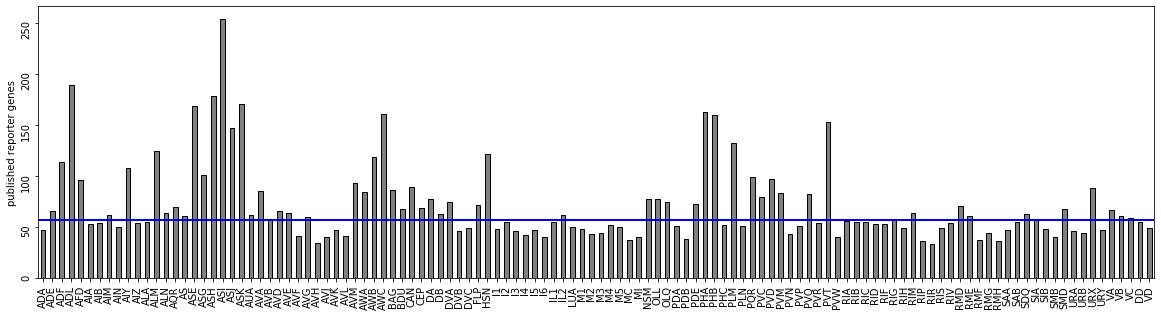

In [99]:


ax=d[['ba','ba_c']].plot.bar(legend=False,stacked=False,figsize=(20,5),color=['grey'],edgecolor='black',rot=90)
#plt.ylim(0,500)
x=d[['ba','ba_c']].loc[d[['ba','ba_c']]['ba_c']!=0]["ba_c"]
ax.axhline(x.median(), color='blue', linewidth=2)
xlabels=d["ba"].drop_duplicates().values
ax.set_xticklabels(xlabels, rotation=90)
plt.yticks(rotation=90)
ax.grid(False)
plt.ylabel("published reporter genes")
plt.savefig('../../output/figure_parts/Fig2_ba_markers_per_neuron_class.pdf')

plt.show()

In [100]:
ba.head(2)

class subclass neuron Neuron Type  acr-5  efhc-1  C33A12.4  K10G6.4  acc-4  \
0   ADA      ADA   ADAL       inter      1       0         0        0      0   
1   ADA      ADA   ADAR       inter      1       0         0        0      0   

   add-1  ...  duxl-1  ztf-11  ztf-18  ztf-26  ztf-3  ztf-4  ztf-7  ztf-9  \
0      0  ...       0       1       1       1      1      1      1      1   
1      0  ...       0       1       1       1      1      1      1      1   

   zip-2  zip-4  
0      1      1  
1      1      1  

[2 rows x 1221 columns]